<h1>Predict Furute Sales</h1>
<a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales", target="_blank">Predict Future Sales</a>
<p>by Safronenkov Roman</p>

In [1]:
import pandas as pd
import numpy as np

import catboost as cb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import gc
import re
from itertools import product

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

<h1>GLOBALS</h1>

In [2]:
lag_list = [1, 2, 3, 4, 12]
cols  = ['date_block_num', 'shop_id', 'item_id']

<h1>Loading data</h1>

<p>I've created some functions which help me to preprocess data and generate new features</p>

In [3]:
from data_preprocessing.utils import load_data, downgrade_type

In [4]:
sales_train, item_categories, items, shops, test = load_data()

In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [7]:
sales_train = downgrade_type(sales_train)

In [8]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int32
shop_id           int32
item_id           int32
item_price        float32
item_cnt_day      float32
dtypes: datetime64[ns](1), float32(2), int32(3)
memory usage: 78.4 MB


In [9]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
item_categories = downgrade_type(item_categories)

In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
items = downgrade_type(items)

In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
shops = downgrade_type(shops)

In [15]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [16]:
test['date_block_num'] = 34 # date block for test set

In [17]:
test = downgrade_type(test)

<h1>Data preprocessing</h1>

<h3>Getting rid of some outliers in data</h3>

Wall time: 7.5 s


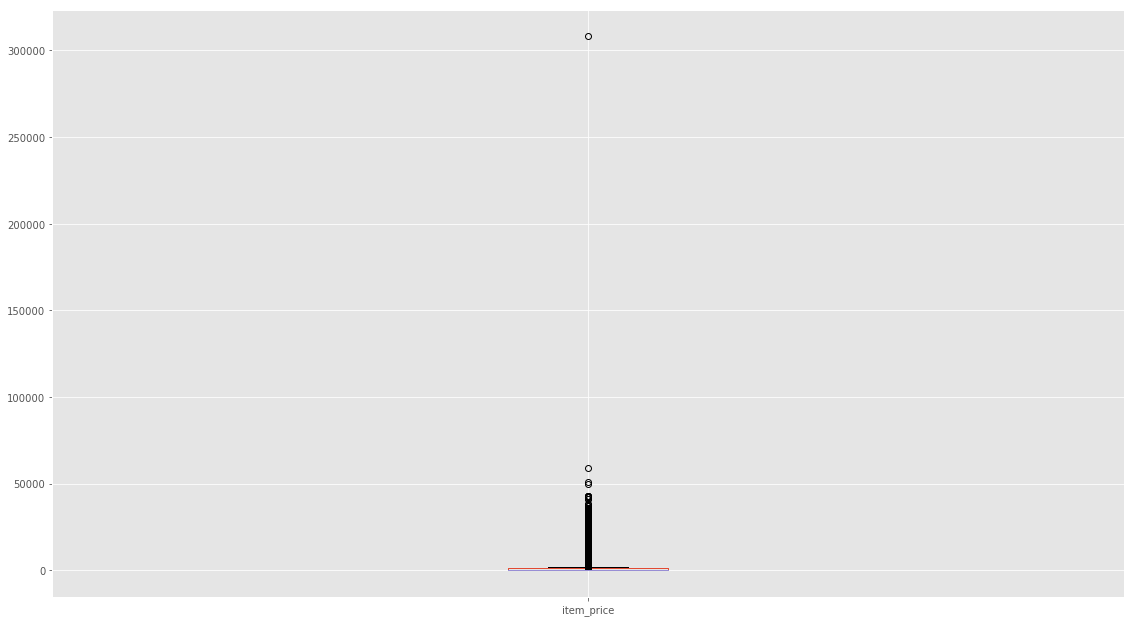

In [18]:
%%time
sales_train.item_price.plot(kind='box', figsize=(19.20, 10.80))

<h3>We don't need price higher than 300000 and lower than 0</h3>

In [19]:
sales_train = sales_train[(sales_train.item_price < 300000) & (sales_train.item_price > 0)].reset_index(drop=True)

Wall time: 7.31 s


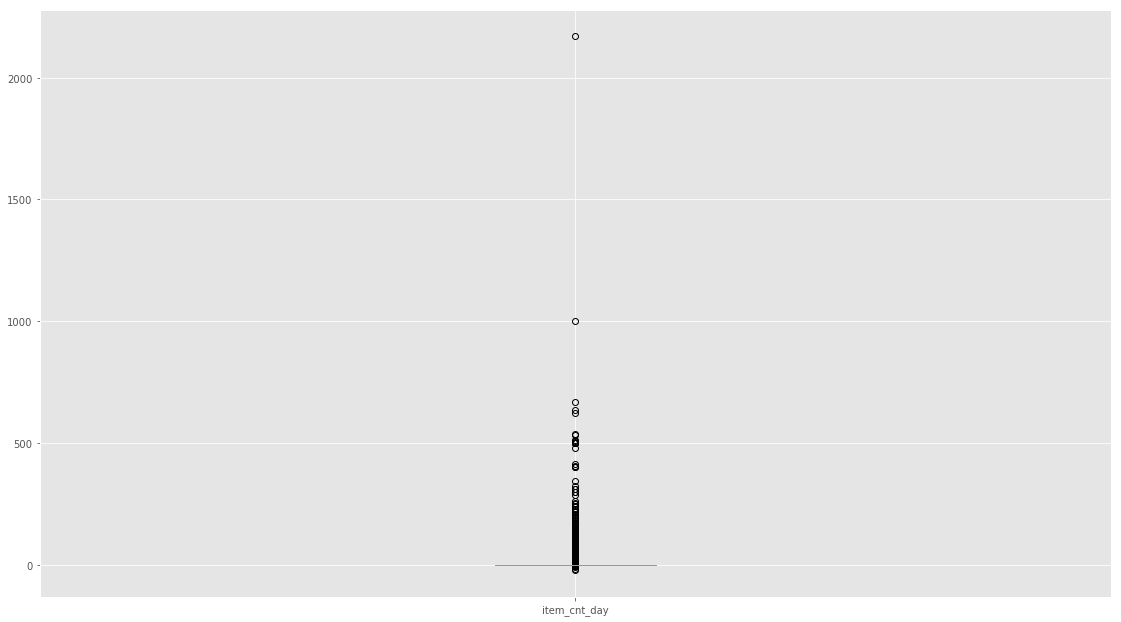

In [20]:
%%time
sales_train.item_cnt_day.plot(kind='box', figsize=(19.20, 10.80))

<h3>Same thing with item_cnt_day</h3>

In [21]:
sales_train = sales_train[(sales_train.item_cnt_day < 1000) & (sales_train.item_cnt_day > 0)].reset_index(drop=True)

Wall time: 7.35 s


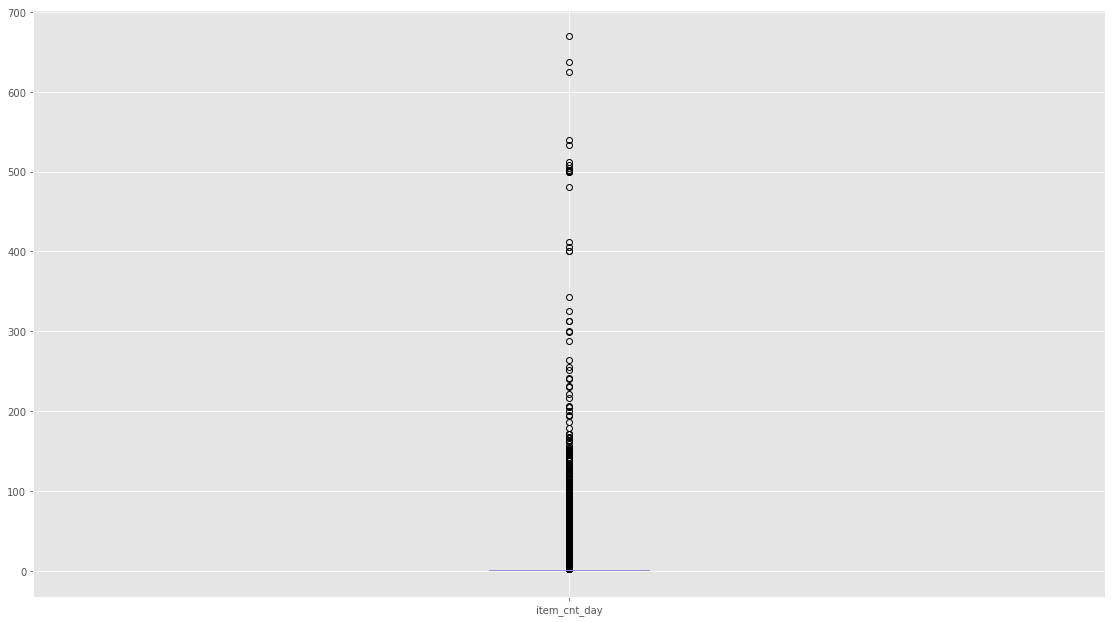

In [22]:
%%time
sales_train.item_cnt_day.plot(kind='box', figsize=(19.20, 10.80))

<h3>Create some categorical features</h3>

In [23]:
shops['city'] = shops.shop_name.str.split(' ').apply(lambda x: x[0]).apply(lambda x: 'Якутск' if x == '!Якутск' else x)

In [24]:
shops['is_s_center'] = shops.shop_name.str.split(' ').apply(lambda x: 'ТЦ' in x).astype(np.int8)

<h1>Train matrix</h1>

<h3>Here I create training data matrix, for every date block every shop and every item which we can see in that date block, i.e. if that item is in that date block but no sales for it there will be 0 sales</h3>

In [25]:
%%time
monthly_train = []

for i in range(34):
    sales = sales_train[sales_train.date_block_num == i]
    monthly_train.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))

monthly_train = pd.DataFrame(np.vstack(monthly_train), columns=cols)
monthly_train['date_block_num'] = monthly_train['date_block_num'].astype(np.int8)
monthly_train['shop_id'] = monthly_train['shop_id'].astype(np.int8)
monthly_train['item_id'] = monthly_train['item_id'].astype(np.int16)
monthly_train.sort_values(cols, inplace=True)

Wall time: 7.52 s


In [26]:
%%time
group = sales_train.groupby(cols).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index( inplace = True)
monthly_train = pd.merge(monthly_train, group, on=cols, how='left')
monthly_train['item_cnt_month'] = monthly_train['item_cnt_month'].fillna(0)

Wall time: 2.69 s


<h1>Feature engineering</h1>

<h3>Here I'll generate some features. Start with concatenating train and test sets</h3>

In [27]:
monthly_train = pd.concat([monthly_train, test.drop('ID', axis=1)],
                          ignore_index=True,
                          keys=cols)

In [28]:
monthly_train = downgrade_type(monthly_train)

<h2>Create target lags</h2>

<h3>With my function I create target lags, i.e. item_cnt_month lags</h3>

In [29]:
from feature_engineering.utils import create_target_lags

In [30]:
%%time

monthly_train = create_target_lags(df=monthly_train, lag_list=lag_list, na_filler=np.nan)

Wall time: 20.4 s


<h2>Create rolling mean target</h2>

<h3>Here I create some rolling means for target with different windows</h3>

In [31]:
from feature_engineering.utils import create_rolling_mean

In [32]:
monthly_train = downgrade_type(create_rolling_mean(df=monthly_train, windowlist=[2, 3, 4], na_filler=np.nan, column='target'))

In [33]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,rolling_mean_target_3,rolling_mean_target_4
7362696,20,0.0,2253,47,0.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0
7575844,21,0.0,6633,27,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
6165610,17,0.0,11311,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8456101,24,0.0,10870,10,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
8120346,23,0.0,3620,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Create rolling std</h1>

<h3>Same thing with rolling standard deviation</h3>

In [34]:
from feature_engineering.utils import create_rolling_std

In [35]:
%%time
monthly_train = downgrade_type(create_rolling_std(df=monthly_train, windowlist=[2, 3, 4], na_filler=np.nan, column='target'))

Wall time: 4.06 s


<h2>Adding lags for average price and rolling mean for it</h2>

<h3>Here I create lags for mean item price for every date, shop, item combination and rolling means for it</h3>

In [36]:
from feature_engineering.utils import create_price_lags

In [37]:
%%time
mean_price_grouped = monthly_train.merge(sales_train[cols+['item_price']], on=cols, how='left').fillna(0)
mean_price_grouped = mean_price_grouped.groupby(cols)['item_price'].mean().reset_index()
mean_price_grouped = create_price_lags(df=mean_price_grouped, lag_list=lag_list, na_filler=np.nan)

Wall time: 27.5 s


In [38]:
%%time
mean_price_grouped = create_rolling_mean(mean_price_grouped, windowlist=[2, 3, 4], na_filler=np.nan, column='mean_item_price')

Wall time: 4.15 s


In [39]:
%%time
monthly_train = monthly_train.merge(mean_price_grouped.drop('item_price', axis=1),
                                    on=['date_block_num', 'shop_id', 'item_id'], how='left')

Wall time: 4.18 s


In [40]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,rolling_std_target_3,rolling_std_target_4,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_4,mean_item_price_lag_12,rolling_mean_mean_item_price_2,rolling_mean_mean_item_price_3,rolling_mean_mean_item_price_4
7507933,21,0.0,12914,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10585680,32,0.0,1453,47,0.0,0.0,NaN,1.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,398.0,0.0,0.0,0.0,99.5
1271835,3,6.0,8891,25,13.0,8.0,NaN,NaN,NaN,10.5,...,NaN,NaN,399.0,399.0,NaN,NaN,NaN,399.0,266.0,199.5
7010346,19,0.0,21910,39,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
8584859,24,0.0,10588,37,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0


In [41]:
# mean for every item price without date or shop dependence
item_price_mean = sales_train.groupby('item_id')['item_price'].mean().reset_index()

In [42]:
monthly_train = monthly_train.merge(item_price_mean, on=['item_id'], how='left')

In [43]:
def find_first_not_nan_price_lag(row):
    """
    for every row in df find first not nan lag and return it, else return 0
    """
    for i in lag_list:
        if not np.isnan(row["mean_item_price_lag_" + str(i)]):
            return row["mean_item_price_lag_" + str(i)]
    return 0

In [44]:
%%time
monthly_train['delta_price'] = monthly_train.apply(find_first_not_nan_price_lag, axis=1)

Wall time: 3min 38s


In [45]:
monthly_train.fillna(0, inplace=True)

In [46]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_4,mean_item_price_lag_12,rolling_mean_mean_item_price_2,rolling_mean_mean_item_price_3,rolling_mean_mean_item_price_4,item_price,delta_price
9211092,26,0.0,11767,47,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,197.771698,0.0
8168511,23,0.0,10347,18,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.900726,0.0
5089863,13,0.0,811,51,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,194.970001,0.0
8888955,25,0.0,9494,38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.333336,0.0
10511385,32,0.0,9994,24,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.308685,0.0


<h3>Find difference between mean item price lag and mean item price for the whole dates and shops</h3>

In [47]:
monthly_train['delta_price'] = (monthly_train['item_price'] - monthly_train['delta_price']) / monthly_train['item_price']

In [48]:
monthly_train.fillna(0, inplace=True)

In [49]:
# I don't need this column anymore
monthly_train.drop('item_price', axis=1, inplace=True)

In [50]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,rolling_std_target_4,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_4,mean_item_price_lag_12,rolling_mean_mean_item_price_2,rolling_mean_mean_item_price_3,rolling_mean_mean_item_price_4,delta_price
10813032,33,0.0,17468,44,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,1.0
789398,2,0.0,19168,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,1.0
9692834,28,0.0,4551,45,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,1.0
11019019,34,0.0,7499,48,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,1.0
5213864,14,0.0,9788,13,0.0,1.0,0.0,0.0,0.0,0.5,...,0.25,0.0,325.0,0.0,0.0,0.0,162.5,108.333333,81.25,1.0


In [51]:
monthly_train.shape

(11098708, 24)

In [52]:
del mean_price_grouped
gc.collect()

451

<h2>Create income lags</h2>

<h3>I create some "income" features. Simply item price multiplied by item count. And rolling means for it</h3>

In [53]:
from feature_engineering.utils import create_income_lags

In [54]:
sales_train['income'] = sales_train['item_price'] * sales_train['item_cnt_day']

In [55]:
%%time
mean_income_stats = monthly_train.merge(sales_train[cols+['income']], on=cols, how='left').fillna(0)
mean_income_stats = mean_income_stats.groupby(cols)['income'].mean().reset_index()

mean_income_stats = create_income_lags(df=mean_income_stats, lag_list=lag_list, na_filler=0)

Wall time: 27.3 s


In [56]:
mean_income_stats = create_rolling_mean(df=mean_income_stats, windowlist=[2, 3, 4], na_filler=0, column='income')

In [57]:
monthly_train = monthly_train.merge(mean_income_stats.drop('income', axis=1),
                                    on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [58]:
monthly_train = downgrade_type(monthly_train)

In [59]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,rolling_mean_mean_item_price_4,delta_price,income_lag_1,income_lag_2,income_lag_3,income_lag_4,income_lag_12,rolling_mean_income_2,rolling_mean_income_3,rolling_mean_income_4
3896980,10,1.0,5625,28,8.0,7.0,8.0,4.0,0.0,7.5,...,2560.833252,-0.000021,3370.000000,3071.666748,2960.00000,3320.000000,0.0,3220.833496,3133.888916,3180.416748
2068884,5,12.0,5033,31,12.0,9.0,14.0,29.0,0.0,10.5,...,1239.193481,-0.075624,1598.611084,1448.875000,2177.50415,3241.052002,0.0,1523.743042,1741.663452,2116.510498
10133653,30,0.0,1211,42,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
632899,1,0.0,17914,41,2.0,0.0,0.0,0.0,0.0,1.0,...,399.750000,-2.211433,1599.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
10789173,33,2.0,8686,38,0.0,1.0,0.0,0.0,0.0,0.5,...,57.250000,1.000000,0.000000,229.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000


In [60]:
del mean_income_stats
gc.collect()

316

<h1>Time-based features</h1>

<h3>Some features that I call time-based</h3>

In [62]:
%%time
# I'll call holidays months 1st and 5th months

dates_subset = sales_train[['date', 'date_block_num']]

dates_subset['month'] = dates_subset.date.dt.month
dates_subset = dates_subset[['date_block_num', 'month']].drop_duplicates().reset_index(drop=True)
dates_subset = dates_subset.append({'date_block_num': 34, 'month': 11}, ignore_index=True)
dates_subset['next_month_holidays'] = dates_subset['month'].isin([12, 4]).astype(int)
dates_items = pd.concat([sales_train[['item_id', 'date_block_num']], test[['item_id', 'date_block_num']]], ignore_index=True)

Wall time: 269 ms


C:\Program Files\Anaconda3\envs\myEnv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [63]:
# date block when each item has been sold for the first time
first_sale_block = dates_items.groupby('item_id')['date_block_num'].min().reset_index()\
.rename(columns={'date_block_num':'first_sale'})

In [64]:
monthly_train = monthly_train.merge(first_sale_block, on='item_id', how='left')

In [65]:
monthly_train = monthly_train.merge(dates_subset[['date_block_num', 'next_month_holidays']], on='date_block_num', how='left')

In [66]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,income_lag_1,income_lag_2,income_lag_3,income_lag_4,income_lag_12,rolling_mean_income_2,rolling_mean_income_3,rolling_mean_income_4,first_sale,next_month_holidays
1731978,4,1.0,4691,42,1.0,0.0,1.0,2.0,0.0,0.5,...,699.0,0.0,699.0,629.0,0.0,0.0,0.0,0.0,0,0
778568,2,0.0,12754,6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2091185,5,0.0,18181,35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
8610777,24,0.0,15342,41,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0
5945491,16,1.0,12487,24,0.0,1.0,1.0,0.0,2.0,0.5,...,0.0,199.0,199.0,0.0,199.0,0.0,0.0,0.0,3,0


In [67]:
del dates_subset, dates_items, first_sale_block
gc.collect()

306

<h1>Categorical features</h1>

<h3>Some categorical features, i.e. binary for Moscow of not and binary for shopping center</h3>

In [68]:
shops['is_in_Moscow'] = shops.shop_name.apply(lambda x: 'Москва' in x).astype(int)

In [69]:
shops

,shop_name,shop_id,city,is_s_center,is_in_Moscow
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,1,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0,0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,0
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,0,0
6,"Воронеж (Плехановская, 13)",6,Воронеж,0,0
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,0,0
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,0,0
9,Выездная Торговля,9,Выездная,0,0


In [70]:
%%time
monthly_train = monthly_train.merge(shops[['shop_id', 'is_in_Moscow', 'city', 'is_s_center']], on='shop_id', how='left')
monthly_train = monthly_train.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
monthly_train = monthly_train.merge(items[['item_id', 'item_category_id']].groupby('item_category_id')['item_id'].count().reset_index()\
.rename(columns={'item_id':'item_count_per_category'}), on='item_category_id', how='left')

Wall time: 6.01 s


In [71]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,rolling_mean_income_2,rolling_mean_income_3,rolling_mean_income_4,first_sale,next_month_holidays,is_in_Moscow,city,is_s_center,item_category_id,item_count_per_category
4687305,12,4.0,14229,38,6.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,10,0,0,Омск,1,30,756
10812604,33,1.0,15785,44,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23,0,0,Самара,1,38,310
7335261,20,0.0,12485,42,1.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0,0,0,СПб,0,55,2365
9160489,26,0.0,4332,37,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,Новосибирск,1,30,756
1506838,4,0.0,4579,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,Волжский,1,55,2365


<h1>Text features</h1>

<h3>Here I extract some features from texts, I haven't used lemmatization or stemming for this, I find it useless in that case. For creating features I join item name, shop name and item category name to be the one text. Then I tokenize created texts and join them back (for deleting useless symbols etc.)<br>Then I use TfidfVectorizer and n-grams with range [2, 3].<br>To create features from that I use TruncatedSVD with 30 components, I haven't time unfortunately to check which is optimal amount.</h3>

In [72]:
from data_preprocessing.text import tokenize_sentence, tokenize_corpus, join_tokenized_sentences

In [73]:
def extract_features_from_text(df):
    print('Making corpuses...')
    corpus_train = df[(df.date_block_num < 33) & (df.date_block_num != 34)]['text_united'].values
    corpus_val = df[(df.date_block_num == 33)]['text_united'].values
    corpus_test = df[(df.date_block_num == 34)]['text_united'].values
    
    print('Tokenizing and joining corpuses...')
    sample_train = join_tokenized_sentences(tokenize_corpus(corpus_train))
    sample_val = join_tokenized_sentences(tokenize_corpus(corpus_val))
    sample_test = join_tokenized_sentences(tokenize_corpus(corpus_test))
    
    print('Fitting vectorizer...')
    vectorizer = TfidfVectorizer(lowercase=False, analyzer='char', ngram_range=[2, 3])
    vectorizer.fit(sample_train)
    
    print('Transforming...')
    train_texts = vectorizer.transform(sample_train)
    val_texts = vectorizer.transform(sample_val)
    test_texts = vectorizer.transform(sample_test)
    
    print('Fitting SVD...')
    svd = TruncatedSVD(n_components=30, random_state=0)
    svd.fit(train_texts)
    print(f'Explained variance: {svd.explained_variance_ratio_.sum()}')
    
    print('Transforming...')
    train_text_features = svd.transform(train_texts)
    val_text_features = svd.transform(val_texts)
    test_text_features = svd.transform(test_texts)
    
    text_features = np.vstack([train_text_features, val_text_features, test_text_features])
    
    text_features = pd.DataFrame(text_features, columns=[f'text_feature_{i}' for i in range(text_features.shape[1])])
    
    return text_features

In [74]:
%%time
text = monthly_train.merge(shops[['shop_name', 'shop_id']], on='shop_id', how='left')
items = items.merge(item_categories, on='item_category_id', how='left')
text = text.merge(items[['item_name', 'item_id', 'item_category_name']], on='item_id', how='left')

text = text[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_name', 'item_name', 'item_category_name']]
text['text_united'] = text['shop_name'] + ' ' + text['item_name'] + ' ' + text['item_category_name']

Wall time: 11 s


In [75]:
%%time
text_features = extract_features_from_text(text)

Making corpuses...
Tokenizing and joining corpuses...
Fitting vectorizer...
Transforming...
Fitting SVD...
Explained variance: 0.2629212113146042
Transforming...
Wall time: 33min 41s


In [76]:
monthly_train = pd.concat([monthly_train, text_features], axis=1)

In [77]:
del text_features, text
gc.collect()

7

<h1>Categorical combinations</h1>

<h3>Categorical features combinations, I could do more, but didn't have enough time</h3>

In [78]:
%%time
monthly_train['item_shop_combination'] = monthly_train['item_id'].apply(str) + '_' + monthly_train['shop_id'].apply(str)

monthly_train['item_category_combination'] = monthly_train['item_id'].apply(str) + '_'\
+ monthly_train['item_category_id'].apply(str)

monthly_train['item_shop_category_combination'] = monthly_train['item_id'].apply(str) \
+ '_' + monthly_train['shop_id'].apply(str) + '_' + monthly_train['item_category_id'].apply(str)

monthly_train['category_item_count_combination'] = monthly_train['item_category_id'].apply(str) + '_'\
+ monthly_train['item_count_per_category'].apply(str)

monthly_train['holidays_in_moscow'] = monthly_train['next_month_holidays'].apply(str) + '_'\
+ monthly_train['is_in_Moscow'].apply(str)

monthly_train['shop_city'] = monthly_train['shop_id'].apply(str) + '_'\
+ monthly_train['city'].apply(str)

Wall time: 29 s


In [79]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,text_feature_26,text_feature_27,text_feature_28,text_feature_29,item_shop_combination,item_category_combination,item_shop_category_combination,category_item_count_combination,holidays_in_moscow,shop_city
2102233,5,0.0,3388,38,0.0,0.0,0.0,0.0,0.0,0.0,...,0.075449,0.024629,0.012077,-0.015903,3388_38,3388_55,3388_38_55,55_2365,0_0,38_Омск
3631307,9,0.0,7672,46,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.054724,0.250050,-0.060436,-0.037764,7672_46,7672_55,7672_46_55,55_2365,0_0,46_Сергиев
2890020,7,0.0,3527,44,0.0,0.0,0.0,1.0,0.0,0.0,...,0.014268,-0.009725,-0.121781,-0.023631,3527_44,3527_77,3527_44_77,77_220,0_0,44_Самара
5946837,16,0.0,16737,24,0.0,0.0,0.0,0.0,4.0,0.0,...,-0.128729,0.048539,-0.025562,-0.091178,16737_24,16737_37,16737_24_37,37_1780,0_1,24_Москва
9767819,29,0.0,9151,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.130457,0.043093,-0.024165,-0.006931,9151_2,9151_40,9151_2_40,40_5035,0_0,2_Адыгея


In [80]:
combinations_list = ['item_shop_combination',
                     'item_category_combination',
                     'item_shop_category_combination',
                     'category_item_count_combination',
                     'holidays_in_moscow',
                     'shop_city']

In [81]:
monthly_train = monthly_train.fillna(0)

<h1>Mean Encodings</h1>

<h3>Here I use mean encoding with expanding mean for each categorical feature except binary ones</h3>

In [82]:
monthly_train['item_cnt_month'] = monthly_train.item_cnt_month.astype(np.float64) # float16 do some infinite values

In [83]:
from feature_engineering.encodings import encode_with_expanding_mean

In [84]:
%%time
monthly_train = encode_with_expanding_mean(monthly_train, 'item_id', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'shop_id', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'item_count_per_category', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'city', 'item_cnt_month', 0.3343)


monthly_train = encode_with_expanding_mean(monthly_train, 'item_shop_combination', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'item_category_combination', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'item_shop_category_combination', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'category_item_count_combination', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'holidays_in_moscow', 'item_cnt_month', 0.3343)
monthly_train = encode_with_expanding_mean(monthly_train, 'shop_city', 'item_cnt_month', 0.3343)

Wall time: 44.3 s


In [85]:
monthly_train.sample(5)

,date_block_num,item_cnt_month,item_id,shop_id,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_12,rolling_mean_target_2,...,item_id_target_enc,shop_id_target_enc,item_count_per_category_target_enc,city_target_enc,item_shop_combination_target_enc,item_category_combination_target_enc,item_shop_category_combination_target_enc,category_item_count_combination_target_enc,holidays_in_moscow_target_enc,shop_city_target_enc
3851323,10,0.0,12998,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029024,0.239336,0.256725,0.493537,0.0,0.029024,0.0,0.256725,0.501856,0.239336
4294175,11,0.0,4889,31,0.0,2.0,1.0,0.0,0.0,1.0,...,0.398406,1.311067,0.663804,0.513705,0.8,0.398406,0.8,0.663804,0.536030,1.311067
6085500,16,1.0,11607,49,0.0,0.0,0.0,0.0,0.0,0.0,...,0.294955,0.082694,0.190449,0.300445,0.0,0.294955,0.0,0.190449,0.284000,0.082694
990703,2,1.0,3738,41,0.0,0.0,0.0,0.0,0.0,0.0,...,1.500000,0.246478,0.951534,0.246478,0.0,1.500000,0.0,0.951534,0.294159,0.246478
7955469,22,0.0,6549,39,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093805,0.117647,0.235899,0.173339,0.0,0.093805,0.0,0.235899,0.277235,0.117647


<h1>Feature selection</h1>

<h3>With lots of tries I've created that list</h3>

In [86]:
columns_to_drop = ['item_cnt_month', 'city']
columns_to_drop += combinations_list

columns_to_drop += ['rolling_std_target_2',
                    'target_lag_3',
                    'rolling_mean_target_3',
                    'mean_item_price_lag_2',
                    'target_lag_4',
                    'target_lag_12',
                    'income_lag_4',
                    'mean_item_price_lag_4',
                    'income_lag_2',
                    'income_lag_3',
                    'mean_item_price_lag_3',
                    'rolling_mean_income_2',
                    'rolling_std_target_4',
                    'rolling_mean_mean_item_price_2',
                    'rolling_std_target_3',
                    'rolling_mean_target_4',
                    'mean_item_price_lag_12',
                    'rolling_mean_mean_item_price_3',
                    'rolling_mean_income_4',
                    'rolling_mean_income_3',
                    'rolling_mean_mean_item_price_4',
                    'is_s_center',
                    'is_in_Moscow',
                    'income_lag_12']

# Modeling

<h3>I used simple weighted averaging of CatBoostRegressor and SGDRegressor</h3>

In [87]:
DATASET = monthly_train[monthly_train.date_block_num < 34]

<h3>In some cases it was better to use the whole data, but sometimes from 12 month</h3>

In [88]:
# DATASET = DATASET[(DATASET.date_block_num >= 12) & (DATASET.date_block_num != 34)].reset_index(drop=True)
DATASET = DATASET[(DATASET.date_block_num != 34)].reset_index(drop=True)

<h3>Setting train/validation split, I guess there was some target leakage, but I haven't enough time to explore it unfortunately</h3>

In [89]:
val = DATASET[DATASET.date_block_num == 33]
x_val = val.drop(columns_to_drop, axis=1)
y_val = np.clip(val['item_cnt_month'], 0, 20) # in the submission we are expect to send answer clipped between 0 and 20

train = DATASET[(DATASET.date_block_num < 33)]
x_train = train.drop(columns_to_drop, axis=1)
y_train = np.clip(train['item_cnt_month'], 0, 20)

<h3>Plot target distributions</h3>

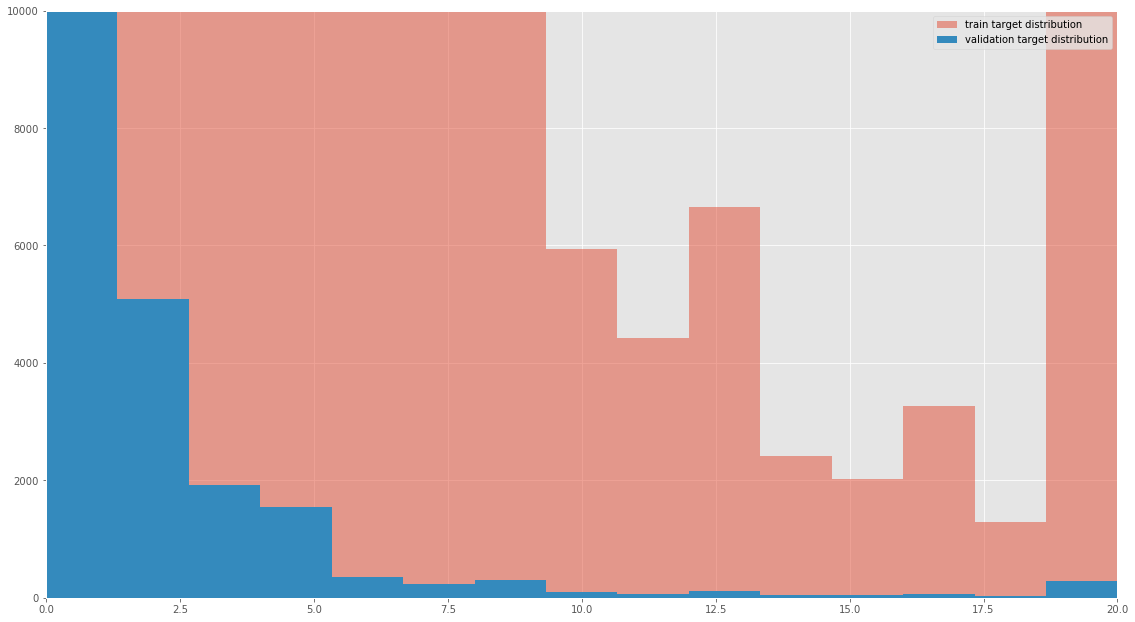

In [90]:
plt.figure(figsize=(19.20, 10.80))
plt.hist(y_train, bins=15, alpha=0.5, label='train target distribution')
plt.hist(y_val,bins=15, label='validation target distribution')
plt.xlim([0, 20])
plt.ylim([-5, 10000])
plt.legend(loc='upper right')
plt.show()

In [91]:
model = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    max_ctr_complexity=6,
    max_depth=10,
    rsm=0.7,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=5,
    random_seed=0
)

In [92]:
%%time
model.fit(
    x_train, y_train,
    eval_set=(x_val, y_val),
    verbose=50
)

0:	learn: 1.2439379	test: 1.1509115	best: 1.1509115 (0)	total: 3.39s	remaining: 56m 27s
50:	learn: 0.8612372	test: 0.8893747	best: 0.8893747 (50)	total: 1m 45s	remaining: 32m 40s
100:	learn: 0.8118892	test: 0.8718813	best: 0.8718813 (100)	total: 3m 21s	remaining: 29m 53s
150:	learn: 0.7952385	test: 0.8666095	best: 0.8666095 (150)	total: 4m 58s	remaining: 27m 56s
200:	learn: 0.7849462	test: 0.8598659	best: 0.8598659 (200)	total: 6m 36s	remaining: 26m 17s
250:	learn: 0.7770967	test: 0.8562954	best: 0.8562954 (250)	total: 8m 15s	remaining: 24m 38s
300:	learn: 0.7706220	test: 0.8525714	best: 0.8525714 (300)	total: 9m 53s	remaining: 22m 58s
350:	learn: 0.7650590	test: 0.8507049	best: 0.8505412 (349)	total: 11m 31s	remaining: 21m 18s
400:	learn: 0.7599347	test: 0.8477989	best: 0.8477989 (400)	total: 13m 9s	remaining: 19m 39s
450:	learn: 0.7557239	test: 0.8453820	best: 0.8453820 (450)	total: 14m 48s	remaining: 18m 1s
500:	learn: 0.7519138	test: 0.8443691	best: 0.8443122 (491)	total: 16m 28s	r

In [93]:
model.best_score_

{'learn': {'RMSE': 0.7270642273202438},
 'validation': {'RMSE': 0.8342305496467042}}

In [94]:
(mean_squared_error(y_train, np.clip(model.predict(x_train), 0, 20), squared=False),
mean_squared_error(y_val, np.clip(model.predict(x_val), 0, 20), squared=False))

(0.7269408745723206, 0.834110679837102)

<h3>CatBoost feature importances</h3>

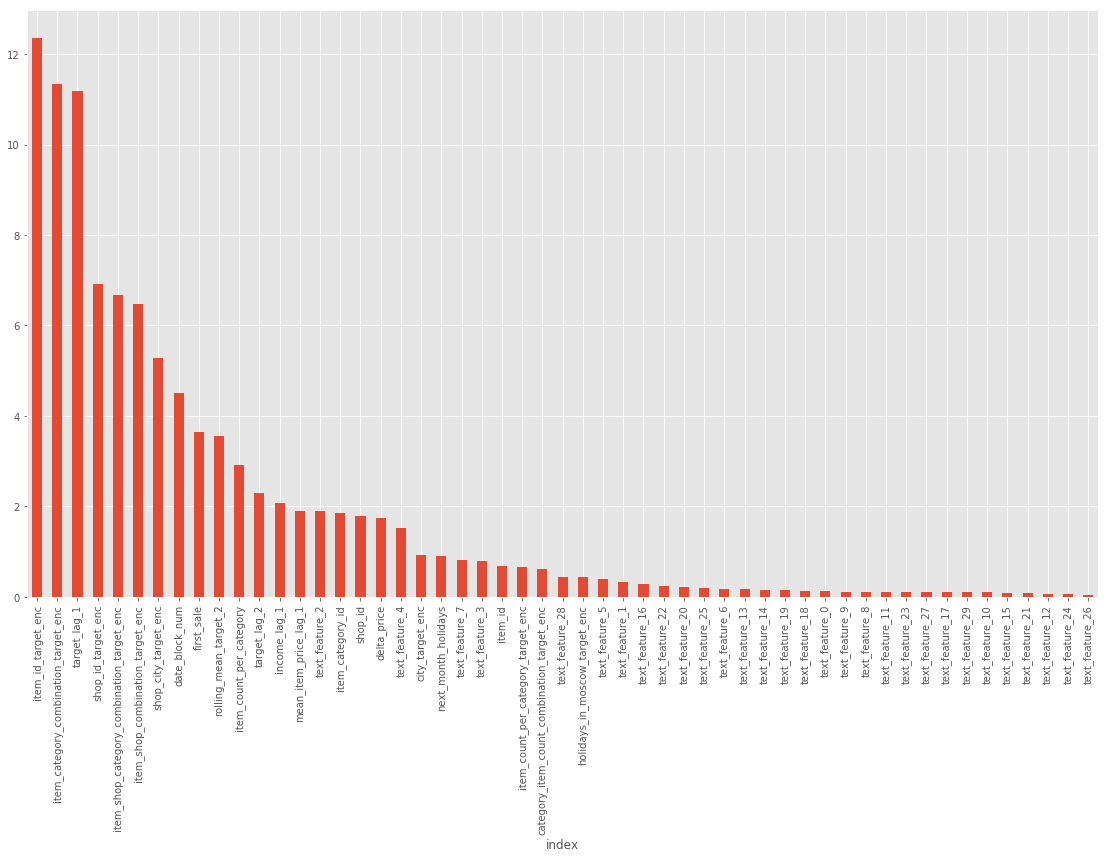

In [95]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_)\
.reset_index().sort_values(0, ascending=False)\
.plot(x='index', y=0, kind='bar', legend=False, figsize=(19.20, 10.80))

<h3>Fitting linear regression, I removed some categoricals and applied MinMaxScaler</h3>

In [96]:
%%time
x_train_for_linreg = x_train.copy()
x_val_for_linreg = x_val.copy()

x_train_for_linreg.drop(['shop_id', 'item_id', 'item_category_id'], axis=1, inplace=True)
x_val_for_linreg.drop(['shop_id', 'item_id', 'item_category_id'], axis=1, inplace=True)

scaler = MinMaxScaler() # linear models are sensitive to features scale

scaler.fit(x_train_for_linreg)

x_train_for_linreg = scaler.transform(x_train_for_linreg)
x_val_for_linreg = scaler.transform(x_val_for_linreg)

Wall time: 6.36 s


In [97]:
linreg = SGDRegressor(random_state=0, penalty='elasticnet', l1_ratio=0.3, verbose=100, learning_rate='adaptive', alpha=0)

In [98]:
%%time
linreg.fit(x_train_for_linreg, y_train)

-- Epoch 1
Norm: 56.05, NNZs: 50, Bias: 7.514271, T: 10646424, Avg. loss: 0.548975
Total training time: 4.88 seconds.
-- Epoch 2
Norm: 61.68, NNZs: 50, Bias: 7.458811, T: 21292848, Avg. loss: 0.539931
Total training time: 9.76 seconds.
-- Epoch 3
Norm: 61.37, NNZs: 50, Bias: 7.385747, T: 31939272, Avg. loss: 0.539597
Total training time: 14.61 seconds.
-- Epoch 4
Norm: 63.88, NNZs: 50, Bias: 7.206844, T: 42585696, Avg. loss: 0.539235
Total training time: 19.42 seconds.
-- Epoch 5
Norm: 65.94, NNZs: 50, Bias: 7.510382, T: 53232120, Avg. loss: 0.539081
Total training time: 24.25 seconds.
-- Epoch 6
Norm: 67.15, NNZs: 50, Bias: 7.160170, T: 63878544, Avg. loss: 0.538926
Total training time: 29.09 seconds.
-- Epoch 7
Norm: 68.34, NNZs: 50, Bias: 7.398678, T: 74524968, Avg. loss: 0.538878
Total training time: 33.97 seconds.
-- Epoch 8
Norm: 68.39, NNZs: 50, Bias: 7.294648, T: 85171392, Avg. loss: 0.519556
Total training time: 38.80 seconds.
-- Epoch 9
Norm: 68.64, NNZs: 50, Bias: 7.331633, 

SGDRegressor(alpha=0, l1_ratio=0.3, learning_rate='adaptive',
             penalty='elasticnet', random_state=0, verbose=100)

In [99]:
mean_squared_error(y_train, np.clip(linreg.predict(x_train_for_linreg), 0, 20), squared=False), \
mean_squared_error(y_val, np.clip(linreg.predict(x_val_for_linreg), 0, 20), squared=False)

(0.995202395403477, 0.9793529273748369)

# Predicting and submission

In [100]:
test_preprocessed = monthly_train[monthly_train.date_block_num == 34].reset_index(drop=True)

x_test = test_preprocessed.drop(columns_to_drop, axis=1)

In [101]:
cat_boost_answ = np.clip(model.predict(x_test), 0, 20)

In [102]:
x_test_for_linreg = x_test.drop(['shop_id', 'item_id', 'item_category_id'], axis=1).fillna(0)
x_test_for_linreg = scaler.transform(x_test_for_linreg)


linreg_answ = np.clip(linreg.predict(x_test_for_linreg), 0, 20)

<h3>Finding the best alpha for averaging</h3>

In [103]:
alphas = []
answ_cb_val = np.clip(model.predict(x_val), 0, 20)
answ_lin_val = np.clip(linreg.predict(x_val_for_linreg), 0, 20)
for alpha in np.arange(0, 1, 0.05):
    result = answ_cb_val * alpha + answ_lin_val * (1 - alpha)
    score = mean_squared_error(y_val, np.clip(result, 0, 20), squared=False)
    alphas.append((alpha, score))

In [104]:
best_alpha = sorted(alphas, key=lambda x: x[1])[0][0]
best_alpha

0.9

<h3>Final answer and submission</h3>

In [105]:
answ = (cat_boost_answ * best_alpha + linreg_answ * (1 - best_alpha))
# answ = (cat_boost_answ * 0.8 + linreg_answ * 0.2)
# answ = cat_boost_answ

In [106]:
test_preprocessed['item_cnt_month'] = np.clip(answ, 0, 20)

In [107]:
answer = test.merge(test_preprocessed[['shop_id', 'item_id', 'item_cnt_month']], on=['shop_id', 'item_id'], how='left')

In [108]:
submission = answer[['ID', 'item_cnt_month']]

In [109]:
submission.to_csv('./submission.csv', index=False)

<h3>As a result I got 0.985114 on public leaderboard, I can do better, I haven't tried a lot of things, i.e. stacking, KNNFeatures, different models, lots of features, word2vec etc. I just haven't enough time for it.</h3>